In [281]:
import numpy as np
import pandas as pd 
import sklearn

In [282]:
df = pd.read_csv('../clean-data/reduced-columns.csv')
df.head()

,FIPS,Asian_by_pop,NewCases,Otherpop_by_pop,Population_density,Confirmed,Median_Hou,NewDeaths,Deaths,Countyname,ST_Name,Older_by_pop,Population
0,1001,0.011953,27,0.001773,0.000022,6702,58731,1,103,Autauga,Alabama,0.172793,55869.0
1,1003,0.011811,15,0.002078,0.000029,20588,58320,-1,300,Baldwin,Alabama,0.256945,223234.0
2,1005,0.004194,5,0.003709,0.000009,2244,32525,0,55,Barbour,Alabama,0.163264,24686.0
3,1007,0.001277,3,0.000000,0.000009,2560,47542,0,58,Bibb,Alabama,0.169488,22394.0
4,1009,0.003916,3,0.003952,0.000022,6472,49358,1,134,Blount,Alabama,0.190717,57826.0


In [283]:
df.shape

(3143, 13)

In [284]:
nan_value = float("NaN")
df = df.replace("", nan_value)
df = df.dropna()

In [285]:
df.shape

(3141, 13)

In [286]:
from sklearn.cluster import DBSCAN

In [287]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

In [288]:
dfCluster = df[['Asian_by_pop','NewCases','Otherpop_by_pop','Population_density','Confirmed','Median_Hou','NewDeaths',
 'Deaths','Older_by_pop','Population']]

dfCluster.head()

,Asian_by_pop,NewCases,Otherpop_by_pop,Population_density,Confirmed,Median_Hou,NewDeaths,Deaths,Older_by_pop,Population
0,0.011953,27,0.001773,0.000022,6702,58731,1,103,0.172793,55869.0
1,0.011811,15,0.002078,0.000029,20588,58320,-1,300,0.256945,223234.0
2,0.004194,5,0.003709,0.000009,2244,32525,0,55,0.163264,24686.0
3,0.001277,3,0.000000,0.000009,2560,47542,0,58,0.169488,22394.0
4,0.003916,3,0.003952,0.000022,6472,49358,1,134,0.190717,57826.0


In [289]:
dfClusterScaled = StandardScaler().fit_transform(dfCluster)
dfClusterScaled

array([[-0.11899648,  0.02640322,  0.17537767, ..., -0.10670772,
         0.16512874, -0.14586713],
       [-0.12227892, -0.10387434,  0.29051179, ...,  0.18178539,
         1.08044099,  0.35605196],
       [-0.29759559, -0.21243897,  0.90604757, ..., -0.17700046,
         0.0614824 , -0.23938336],
       ...,
       [-0.35626028, -0.26672129, -0.49392822, ..., -0.23997103,
        -0.22368606, -0.25275867],
       [-0.39413791, -0.25586482,  0.26300432, ..., -0.21946899,
         0.74752366, -0.29000862],
       [-0.20770334, -0.26672129, -0.49392822, ..., -0.25022206,
         0.52077023, -0.29264169]])

In [290]:
# Density-based spatial clustering of applications with noise (DBSCAN) 
#  min_samples = 2*dimensions (# of features)
# 
db = DBSCAN(eps=0.5, min_samples=15).fit(dfClusterScaled)

In [291]:
labels = db.labels_

In [292]:
set(labels)

{-1, 0, 1, 2}

In [293]:
df["DBCluster_#"] = labels

In [294]:
# from sklearn.neighbors import NearestNeighbors
# from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set()

# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(dfClusterScaled)
# distances, indices = nbrs.kneighbors(dfClusterScaled)
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.plot(distances)

In [295]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(dfClusterScaled, quantile=0.95,n_jobs=-1)


In [296]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(dfClusterScaled)
mslabels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(mslabels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)



number of estimated clusters : 20


In [297]:
# set(mslabels)
mslabels.shape
df["MeanShiftCluster_#"] = mslabels

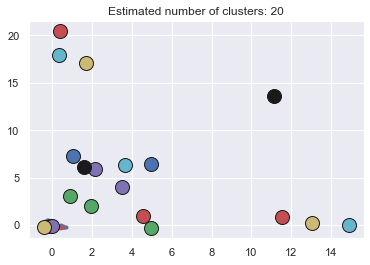

In [298]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(dfClusterScaled[my_members, 0], dfClusterScaled[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [299]:
# Not working well with scaled data
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering().fit(dfCluster)
spectralLabels = clustering.labels_
set(clustering.labels_)

C:\Users\asyed\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


{0, 1, 2, 3, 4, 5, 6, 7}

In [300]:
len(spectralLabels)
df["SpectralCluster_#"] = spectralLabels

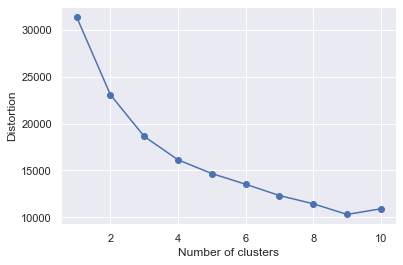

In [301]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dfClusterScaled)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [302]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(dfClusterScaled)
kmeansLabels = kmeans.labels_

# kmeans.cluster_centers_
set(kmeansLabels)
df["KMeans_#"] = kmeansLabels

In [303]:
len(kmeansLabels)

3141

In [304]:
df.to_csv('ClusteredData.csv')
df.to_csv('../clean-data/ClusteredData.csv')